# POP MOC(z) for 0.1-degree
 - Computes MOC(z) offline from POP history files using simple xhistogram binning

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import glob
import dask
from xhistogram.xarray import histogram
import matplotlib.pyplot as plt
%matplotlib inline

from MOCutils import popmoc

ModuleNotFoundError: No module named 'MOCutils'

In [ ]:
from dask.distributed import wait
dask.__version__

### Dask Cluster

In [22]:
# Close out Dask Cluster and release workers:
cluster.close()
client.close()

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(36) 

In [4]:
cluster

### Read in history file data & MOC template file

In [5]:
def time_set_midmonth(ds, time_name, deep=False):
    """
    Return copy of ds with values of ds[time_name] replaced with mid-month
    values (day=15) rather than end-month values.
    """
    #ds_out = ds.copy(deep)
    year = ds[time_name].dt.year
    month = ds[time_name].dt.month
    year = xr.where(month==1,year-1,year)
    month = xr.where(month==1,12,month-1)
    nmonths = len(month)
    newtime = [cftime.DatetimeNoLeap(year[i], month[i], 15) for i in range(nmonths)]
    ds[time_name] = newtime
    return ds

def preprocessor(ds0):
    keepvars = ['VVEL','WVEL']
    d0 = ds0[keepvars]
    d0 = time_set_midmonth(d0,'time')
    #d0 = d0.groupby('time.year').mean('time').rename({'year':'time'})
    return d0

In [6]:
fdir = '/glade/campaign/cgd/oce/people/whokim/csm/g.e21.GRYF_0304.TL319_t13.003/ocn/hist/'

fin = fdir + 'g.e21.GRYF_0304.TL319_t13.003.pop.h.0060-??.nc'
ds = xr.open_mfdataset(fin,combine='by_coords',
                       preprocess=preprocessor,chunks={'time':1,'nlon':300},
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,)

#fin = fdir + 'g.e21.GRYF_0304.TL319_t13.003.pop.h.0060-01.nc'
#ds = xr.open_dataset(fin,chunks={'time':1,'nlon':150})

fgrd = '/glade/work/whokim/grid/POP.TL319_t13.grid.nc'
ds_grid = xr.open_dataset(fgrd)

fmoc = '/glade/u/home/yeager/analysis/python/POP_MOC/moc_template.nc'
ds_moctemp = xr.open_dataset(fmoc)

In [7]:
ds.WVEL

<xarray.DataArray 'WVEL' (time: 12, z_w_top: 62, nlat: 2400, nlon: 3600)>
dask.array<concatenate, shape=(12, 62, 2400, 3600), dtype=float32, chunksize=(1, 62, 2400, 300), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0060-01-15 00:00:00 ... 0060-12-15 00:00:00
  * z_w_top  (z_w_top) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05 5.75e+05
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 300), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 300), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 300), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 300), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Vertical Velocity
    units:         centimeter/s
    grid_loc:      3112
    cell_methods:  time: mean

### Compute Volume Fluxes

In [8]:
%%time
v_e = ds['VVEL']
v_e = v_e.where(v_e<1.e30,0)
w_e = ds['WVEL'].drop(['ULONG','ULAT'])
w_e = w_e.where(w_e<1.e30, 0)

CPU times: user 6.72 ms, sys: 0 ns, total: 6.72 ms
Wall time: 6.73 ms


In [9]:
# shift VVEL to 3121 position
def shiftVVEL(v):
    v_w = v.roll(nlon=1,roll_coords=False)
    v = 0.5*(v+v_w)
    return v.drop(['ULONG','TLAT'])

v_e = shiftVVEL(v_e)

In [10]:
%%time
# grid-oriented volume fluxes in m^3/s
tarea = ds_grid['TAREA'].drop(['ULONG','ULAT']).astype(w_e.dtype)
w_e = w_e*tarea/1.e6
dxdz = (ds_grid['HTN'].drop(['ULONG','TLAT'])*ds_grid['dz']).astype(v_e.dtype)
v_e = v_e*dxdz/1.e6

CPU times: user 7.79 s, sys: 2.02 s, total: 9.81 s
Wall time: 27.7 s


#### add an extra level corresponding to zero values at ocean floor. (requires rechunking)

In [11]:
w_e_bot = xr.zeros_like(w_e.isel(z_w_top=-1))
w_e_bot['z_w_top'] = ds_grid.z_w_bot[-1].data
wflux = xr.concat([w_e,w_e_bot],dim='z_w_top').rename({'z_w_top':'moc_z'}).chunk({'moc_z':63})

v_e_bot = xr.zeros_like(v_e.isel(z_t=-1))
v_e_bot['z_t'] = ds_grid.z_w_bot[-1].data
vflux = xr.concat([v_e,v_e_bot],dim='z_t').chunk({'z_t':63})

### MOC Region Mask

In [12]:
## Define the MOC region mask:
rmask = ds_grid.REGION_MASK.drop(['ULONG','ULAT'])
rmaskglob = xr.where((rmask>0),1,0)
rmaskatl = xr.where((rmask>=6) & (rmask<=11),1,0)
rmaskmoc = xr.concat([rmaskglob,rmaskatl],dim=ds_moctemp.transport_regions)

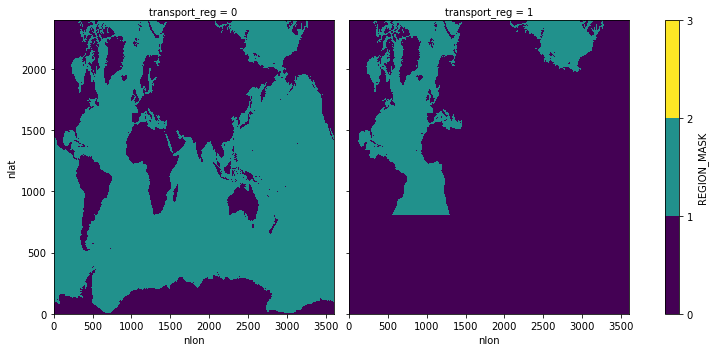

In [13]:
rmaskmoc.plot(levels=[0,1,2,3],col='transport_reg',size=5);

### Compute MOC

In [14]:
%%time
MOC = popmoc.compute_MOC(wflux,rmaskmoc,ds_moctemp.lat_aux_grid)
#daskout = wait(MOC)

CPU times: user 463 ms, sys: 302 ms, total: 765 ms
Wall time: 948 ms


In [15]:
MOC

<xarray.DataArray 'MOC' (time: 12, moc_z: 63, transport_reg: 2, lat_aux_grid: 395)>
dask.array<truediv, shape=(12, 63, 2, 395), dtype=float64, chunksize=(1, 63, 2, 394), chunktype=numpy.ndarray>
Coordinates:
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * time               (time) object 0060-01-15 00:00:00 ... 0060-12-15 00:00:00
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.75e+05 6e+05
    transport_regions  (transport_reg) |S256 b'Global Ocean - Marginal Seas' ...
Dimensions without coordinates: transport_reg
Attributes:
    long_name:  Meridional Overturning Circulation
    units:      Sv

In [16]:
%%time
MOC = MOC.load()

CPU times: user 10.6 s, sys: 567 ms, total: 11.1 s
Wall time: 54.9 s


### Add Atlantic southern boundary overturning (this includes throughflow)

In [17]:
# determine j=index of Atlantic region southern boundary
tmp = rmaskmoc.isel(transport_reg=1).sum('nlon')
atl_j = 0
j = 0
while (atl_j==0):
    if (tmp.isel(nlat=j).data>0):
        atl_j = j
    j += 1
atl_j = atl_j - 1
atl_j

809

In [18]:
# add vflux at southern boundary of Atlantic domain
tmp = vflux*(rmaskmoc.shift(nlat=-1))
tmp = tmp.isel(nlat=atl_j,transport_reg=1).sum('nlon').rename({'z_t':'moc_z'})
mocatl_s = -tmp.sortby('moc_z',ascending=False).cumsum('moc_z').sortby('moc_z',ascending=True)/1.e6
mocatl_s['moc_z'] = MOC['moc_z']

In [19]:
%%time
mocatl_s = mocatl_s.load()

CPU times: user 12.9 s, sys: 2.26 s, total: 15.2 s
Wall time: 46.1 s


In [20]:
MOC[{'transport_reg':1}] = MOC[{'transport_reg':1}] + mocatl_s

## Plots

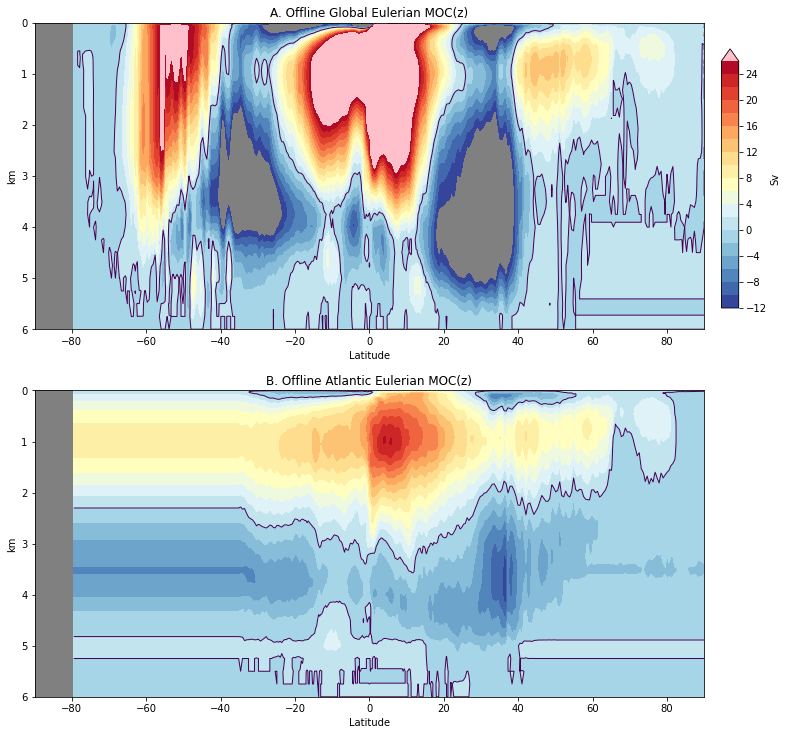

In [21]:
# Plot MOC
import copy

fig = plt.figure(figsize=(12,12))
mnlevs = np.arange(0,20,1)*2. - 12.
mycmap = copy.copy(plt.cm.RdYlBu_r)
xlim=[-30,70]
ylim=[6,0]

tr = 0   # transport_reg
trstr = 'Global'
compstr = 'Eulerian'

ax = fig.add_subplot(2,1,1)
ax.set_title('A. Offline {} {} MOC(z)'.format(trstr,compstr))
cntr1 = ax.contourf(MOC.lat_aux_grid, MOC.moc_z/1.e5, MOC.isel(time=0,transport_reg=tr),levels=mnlevs, cmap=mycmap,extend='max')
ax.contour(MOC.lat_aux_grid, MOC.moc_z/1.e5, MOC.isel(time=0,transport_reg=tr),levels=[0.], linewidths=1)
cntr1.cmap.set_over('pink')
ax.set_ylim([6,0])
ax.set_xlim([-90,90])
ax.set_xlabel('Latitude')
ax.set_ylabel('km')
ax.set_facecolor('grey')

tr = 1   # transport_reg
trstr = 'Atlantic'

ax = fig.add_subplot(2,1,2)
ax.set_title('B. Offline {} {} MOC(z)'.format(trstr,compstr))
cntr2 = ax.contourf(MOC.lat_aux_grid, MOC.moc_z/1.e5, MOC.isel(time=0,transport_reg=tr),levels=mnlevs, cmap=mycmap,extend='max')
ax.contour(MOC.lat_aux_grid, MOC.moc_z/1.e5, MOC.isel(time=0,transport_reg=tr),levels=[0.], linewidths=1)
cntr2.cmap.set_over('pink')
ax.set_ylim([6,0])
ax.set_xlim([-90,90])
ax.set_xlabel('Latitude')
ax.set_ylabel('km')
ax.set_facecolor('grey')


fig.subplots_adjust(bottom=0.1,right=0.9)
cbar_ax = fig.add_axes([0.92, 0.55, 0.02, 0.3])
fig.colorbar(cntr1, cax=cbar_ax, label='Sv', orientation='vertical')

### Write to netcdf

In [23]:
# Compute annual mean MOC
MOCann = MOC.groupby('time.year').mean('time').rename({'year':'time'})

In [24]:
MOCann.to_netcdf('/glade/scratch/yeager/testMOCz_0p1degPOP.nc')